# 🚗 Fine-tune TrOCR on UK Car Plate VRN Dataset (Optimized for Speed & Storage)

In [2]:
import os
from PIL import Image
from datasets import load_dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch


## Download the UK Number Plate Data from Hugging Face

In [87]:
# Load training examples
dataset = load_dataset("spawn99/UK-Car-Plate-VRN-Dataset", split="train[:150]")
dataset[0]


{'vrn': 'VW75XIG',
 'front_plate': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x96>,
 'rear_plate': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x96>,
 'augmented_front_plate': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448>,
 'augmented_rear_plate': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448>}

## Use the classicication model on Hugging Face that is developed by microsoft originally used for recognizing handwritten characters

In [89]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Required configs for decoder
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

## Create the trainning process based on the dataset

##### The dataset is created such that the first column is VRN which is the plate number and the second column to be the picture of front plate

In [91]:
def preprocess(example):
    image = example["front_plate"].convert("RGB")
    text = example["vrn"]
    encoding = processor(images=image, text=text, return_tensors="pt", padding="max_length", truncation=True, max_length=16)
    return {
        "pixel_values": encoding.pixel_values.squeeze(),
        "labels": encoding.labels.squeeze()
    }

dataset = dataset.map(preprocess)


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [92]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-uk-plate-finetune",
    per_device_train_batch_size=2,
    num_train_epochs=5,
    predict_with_generate=True,
    save_strategy="no",  # Disable checkpoint saving
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=torch.cuda.is_available()
)


In [95]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor
)


C:\Users\Yilin Chen\AppData\Local\Temp\ipykernel_5488\4079754485.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [97]:
trainer.train()


Step,Training Loss
10,4.382100
20,1.046800
30,0.933800
40,0.873300
50,0.609800
60,0.751000
70,0.653900
80,0.486300
90,0.380200
100,0.475600


TrainOutput(global_step=375, training_loss=0.43836189007759097, metrics={'train_runtime': 1423.115, 'train_samples_per_second': 0.527, 'train_steps_per_second': 0.264, 'total_flos': 5.61213893246976e+17, 'train_loss': 0.43836189007759097, 'epoch': 5.0})

In [99]:
model.save_pretrained("./trocr-uk-plate-final")
processor.save_pretrained("./trocr-uk-plate-final")


[]

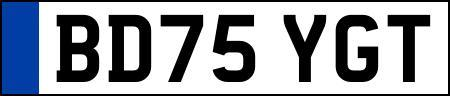

In [140]:
from IPython.display import Image
Image("testplate1.jpg")

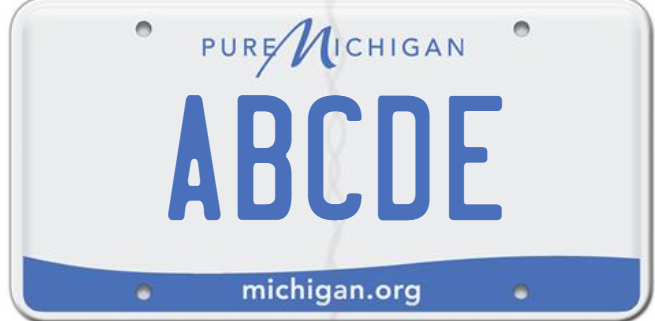

In [138]:
Image("testplate3.png")

# Results after training based on 150 datasets

In [125]:
from PIL import Image

# Load and prepare a new license plate image
image = Image.open("testplate1.jpg").convert("RGB")

# Preprocess
# Preprocess for inference
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Generate prediction
generated_ids = model.generate(inputs["pixel_values"])
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted plate:", predicted_text)

Predicted plate: BDYYYYYYYYYYYY


In [127]:
image = Image.open("testplate3.png").convert("RGB")

# Preprocess
# Preprocess for inference
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Generate prediction
generated_ids = model.generate(inputs["pixel_values"])
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted plate:", predicted_text)

Predicted plate: AADEDEE


#### We can see the result have recognize some of the pattern of a number plate. However, duo to the lack of the memory of the computer. The model was unable to be trained on a larger dataset. So there existing some mistake on recognizing the plate correctly. Furthermore, the microsoft/trocr-base-handwritten model seems to have better ablilty of recognize characters better than numbers. That may causing the model to recognize num